## Import Libaries

In [2]:

# ## Import Libaries


import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from utils.dl_helper_functions import (
    create_sequences,
    load_picture_lagged_data,
    scale_data,
)
from xgboost import XGBRegressor

HORIZON = 24 * 3 # 3 days of forecast
INITIAL_TRAINING_SIZE = 24 * 183   # 6 months of data = 4392 h
SEQUENCE_LENGTH = 24  # 1 day of data
DTYPE_NUMPY = np.float32  # Use float32 for numpy arrays
n_jobs = -1  # Use all available CPU cores for parallel processing


# # Load Data
X, y_lagged, y, common_time = load_picture_lagged_data(return_common_time=True, verbose=False, grid_size=5, n_jobs=n_jobs, dtype=DTYPE_NUMPY, pca=True)


100%|██████████| 20161/20161 [00:02<00:00, 7477.68it/s]


                 time  bottomT_PC_1  sla_PC_1  sla_PC_2   so_PC_1   so_PC_2  \
0 2022-12-09 22:00:00      0.634133  0.925309 -0.457366 -0.100705 -0.897528   
1 2022-12-09 23:00:00      0.637294  0.940802 -0.442214 -0.111268 -0.912123   
2 2022-12-10 00:00:00      0.639464  0.945689 -0.414826 -0.122708 -0.920838   
3 2022-12-10 01:00:00      0.638936  0.965772 -0.330261 -0.133696 -0.925385   
4 2022-12-10 02:00:00      0.641412  0.952780 -0.323189 -0.143205 -0.932978   

    so_PC_3  sob_PC_1  sob_PC_2  thetao_PC_1   uo_PC_1   uo_PC_2   uo_PC_3  \
0  2.029672  0.280786 -0.082470    -0.553418  0.653585 -0.046777  0.145592   
1  2.036069  0.293755 -0.104575    -0.554901  0.482343 -0.024300  0.008832   
2  2.038312  0.307333 -0.125272    -0.556919  0.236408 -0.041806 -0.088139   
3  2.038564  0.321025 -0.144447    -0.555702  0.027601 -0.015676 -0.083613   
4  2.051886  0.334548 -0.161840    -0.557908 -0.064479  0.086782 -0.048168   

    uo_PC_4   uo_PC_5   vo_PC_1   vo_PC_2   vo_PC_3   vo

In [ ]:
import optuna


# convert X, y_lagged, y to numpy arrays of type float32
X = X.astype(DTYPE_NUMPY)
y_lagged = y_lagged.astype(DTYPE_NUMPY)
y = y.astype(DTYPE_NUMPY)

print(f"X shape: {X.shape}, y_lagged shape: {y_lagged.shape}, y shape: {y.shape}, common_time shape: {common_time.shape}")


# Modellwahl: eines von ['RandomForest', 'SVR', 'XGBoost', 'LGBM', 'Linear']
model_name = "Linear"


def get_model(name):
    if name == "RandomForest":
        return RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=n_jobs)
    elif name == "SVR":
        return MultiOutputRegressor(SVR(), n_jobs=n_jobs)
    elif name == "XGBoost":
        return MultiOutputRegressor(XGBRegressor(n_estimators=500, random_state=42, n_jobs=n_jobs), n_jobs=n_jobs)
    elif name == "LGBM":
        return MultiOutputRegressor(LGBMRegressor(n_estimators=500, random_state=42, n_jobs=n_jobs), n_jobs=n_jobs)
    elif name == "Linear":
        return MultiOutputRegressor(LinearRegression(n_jobs=n_jobs), n_jobs=n_jobs)
    else:
        raise ValueError(f"Unbekanntes Modell: {name}")

folds = {
    "Surge1": pd.Timestamp("2023-02-25 16:00:00"),
    "Surge2": pd.Timestamp("2023-04-01 09:00:00"),
    "Surge3": pd.Timestamp("2023-10-07 20:00:00"),
    "Surge4": pd.Timestamp("2023-10-20 21:00:00"),
    "Surge5": pd.Timestamp("2024-01-03 01:00:00"),
    "Surge6": pd.Timestamp("2024-02-09 15:00:00"),
    "Surge7": pd.Timestamp("2024-12-09 10:00:00"),
    "normal1": pd.Timestamp("2025-01-05 14:00:00"),
    "normal2": pd.Timestamp("2025-02-10 18:00:00"),
    "normal3": pd.Timestamp("2025-03-15 12:00:00"),
}


# get idx in X of folds
folds_idx = [np.where(common_time == fold)[0][0] for fold in folds.values()]

print(f"Folds: {folds}")
print(f"Folds idx: {folds_idx}")
delta = 168 * 4 # 4 weeks in hours
time_delta = pd.Timedelta(hours=delta)

# Scale the data
X_scaler = StandardScaler()
y_lagged_scaler = StandardScaler()

results = pd.DataFrame()




def cross_validation_loop(model_name, folds, X, y_lagged, y, common_time, time_delta):

    fold_results = []
    # Cross-Validation Loop
    for surge_name, fold in folds.items():
        start_cutoff = fold - time_delta
        end_cutoff = fold + time_delta
        print(f"Start Cutoff: {start_cutoff}, End Cutoff: {end_cutoff}")

        idx_start_cutoff = np.where(common_time == start_cutoff)[0][0]
        idx_end_cutoff = np.where(common_time == end_cutoff)[0][0]


        

        # Cut the data to the specified time range
        X_test = X[idx_start_cutoff:idx_end_cutoff]
        y_lagged_test = y_lagged[idx_start_cutoff:idx_end_cutoff]
        y_test = y[idx_start_cutoff:idx_end_cutoff]

        # make from idx_start_cutoff to idx_end_cutoff in X to NaN
        X_train = X.copy()
        X_train[idx_start_cutoff:idx_end_cutoff] = np.nan
        y_lagged_train = y_lagged.copy()
        y_lagged_train[idx_start_cutoff:idx_end_cutoff] = np.nan
        y_train = y.copy()
        y_train[idx_start_cutoff:idx_end_cutoff] = np.nan
        
        
        X_train, y_lagged_train, y_train = create_sequences(X_data=X_train, 
                                                            y_lagged_data=y_lagged_train, 
                                                            y_data=y_train, 
                                                            seq_len=SEQUENCE_LENGTH,
                                                            horizon=24,
                                                            dtype=DTYPE_NUMPY)
        
        X_test, y_lagged_test, y_test = create_sequences(X_data=X_test, 
                                                    y_lagged_data=y_lagged_test, 
                                                    y_data=y_test, 
                                                    seq_len=SEQUENCE_LENGTH,
                                                    horizon=24,
                                                    dtype=DTYPE_NUMPY)
        
        gap = 168  # 7 days in hours
        # delete the first and the last gap hours from X_test, y_lagged_test, y_test
        X_test = X_test[gap:-gap]
        y_lagged_test = y_lagged_test[gap:-gap]
        y_test = y_test[gap:-gap]



        

        data = scale_data(X_scaler=X_scaler,
                        y_lagged_scaler=y_lagged_scaler,
                        X_train=X_train,
                        y_lagged_train=y_lagged_train,
                        y_train=y_train,
                        X_val=None,
                        y_lagged_val=None,
                        y_val=None,
                        X_test=X_test,
                        y_lagged_test=y_lagged_test,
                        y_test=y_test,dtype=DTYPE_NUMPY)

        X_train, y_lagged_train, y_train, _, _, _, X_test, y_lagged_test, y_test = data

        print(f"X_train shape: {X_train.shape}, y_lagged_train shape: {y_lagged_train.shape}, y_train shape: {y_train.shape}")


        # Machine Learning Part
        X_train = np.hstack([X_train.reshape(X_train.shape[0], -1), y_lagged_train.reshape(X_train.shape[0], -1)])
        X_test = np.hstack([X_test.reshape(X_test.shape[0], -1), y_lagged_test.reshape(X_test.shape[0], -1)])
        
        # convert array to dtype
        X_train = X_train.astype(DTYPE_NUMPY)
        y_train = y_train.astype(DTYPE_NUMPY)
        X_test = X_test.astype(DTYPE_NUMPY)
        y_test = y_test.astype(DTYPE_NUMPY)

        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


        model = get_model(model_name)



        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)


        # calculate the mse
        mse = mean_squared_error(y_test, y_pred)

        
        print(f"Mean Squared Error for fold {fold}: {mse}")
        fold_results.append(mse)
        break
    return fold_results
cross_validation_loop(model_name, folds, X, y_lagged, y, common_time, time_delta)

X shape: (19995, 32), y_lagged shape: (19995, 56), y shape: (19995,), common_time shape: (19995,)
Folds: {'Surge1': Timestamp('2023-02-25 16:00:00'), 'Surge2': Timestamp('2023-04-01 09:00:00'), 'Surge3': Timestamp('2023-10-07 20:00:00'), 'Surge4': Timestamp('2023-10-20 21:00:00'), 'Surge5': Timestamp('2024-01-03 01:00:00'), 'Surge6': Timestamp('2024-02-09 15:00:00'), 'Surge7': Timestamp('2024-12-09 10:00:00'), 'normal1': Timestamp('2025-01-05 14:00:00'), 'normal2': Timestamp('2025-02-10 18:00:00'), 'normal3': Timestamp('2025-03-15 12:00:00')}
Folds idx: [1866, 2699, 7246, 7559, 9339, 10241, 17532, 18184, 19052, 19838]
Start Cutoff: 2023-01-28 16:00:00, End Cutoff: 2023-03-25 16:00:00


Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 2773.06it/s]


X_train shape: (18557, 24, 32), y_lagged_train shape: (18557, 24, 56), y_train shape: (18557, 24)
X_train shape: (18557, 2112), y_train shape: (18557, 24)
X_test shape: (961, 2112), y_test shape: (961, 24)
Mean Squared Error for fold 2023-02-25 16:00:00: 0.03769581392407417


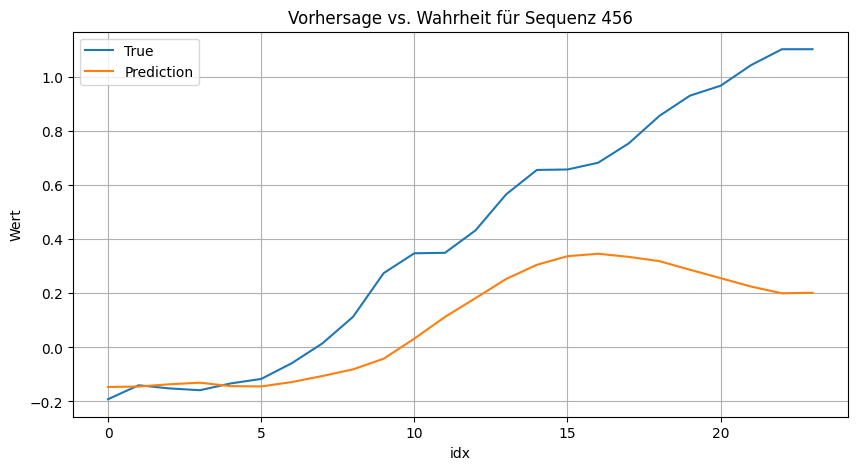

In [33]:
import matplotlib.pyplot as plt

# Beispiel: Plot der ersten Sequenz (Index 0)
seq_idx = len(y_test) // 2 - 24  # oder ein beliebiger Index von 0 bis 1296

plt.figure(figsize=(10, 5))
plt.plot(y_test[seq_idx], label="True")
plt.plot(y_pred[seq_idx], label="Prediction")
plt.xlabel("idx")
plt.ylabel("Wert")
plt.title(f"Vorhersage vs. Wahrheit für Sequenz {seq_idx}")
plt.legend()
plt.grid()
plt.show()

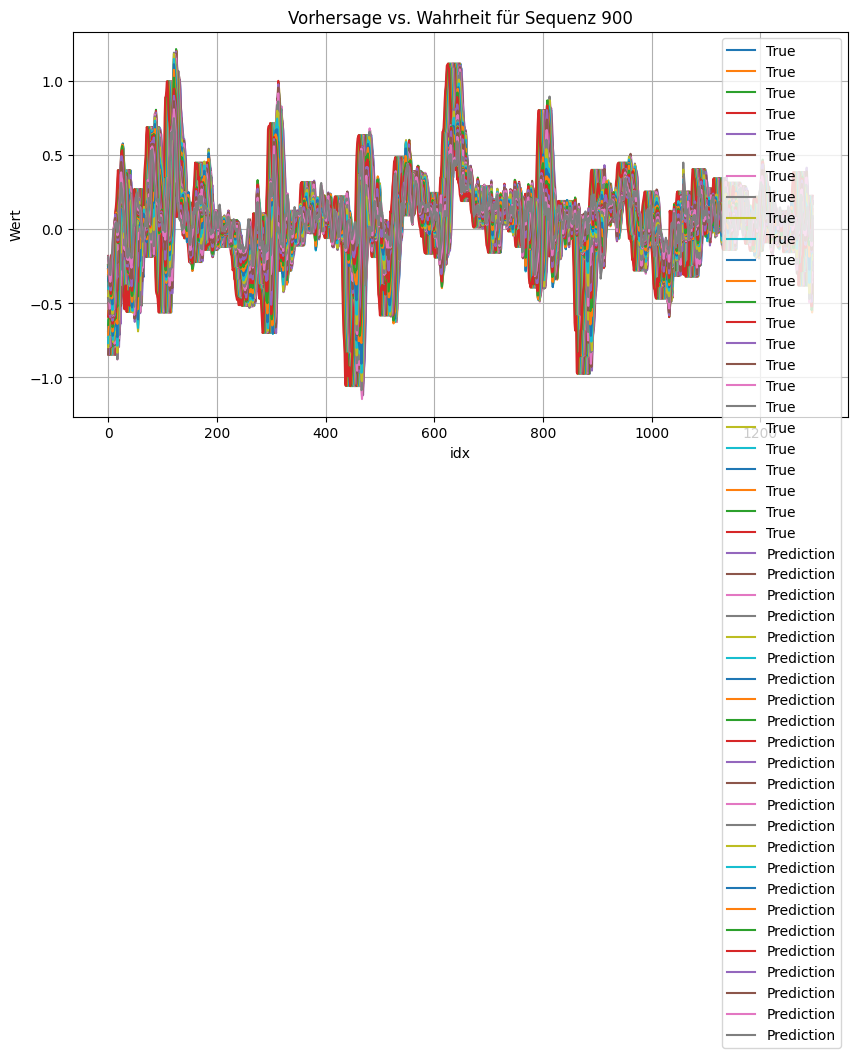

In [9]:
import matplotlib.pyplot as plt

# Beispiel: Plot der ersten Sequenz (Index 0)
seq_idx = 900  # oder ein beliebiger Index von 0 bis 1296

plt.figure(figsize=(10, 5))
plt.plot(y_test[:], label="True")
plt.plot(y_pred[:], label="Prediction")
plt.xlabel("idx")
plt.ylabel("Wert")
plt.title(f"Vorhersage vs. Wahrheit für Sequenz {seq_idx}")
plt.legend()
plt.grid()
plt.show()

## V2


Fold 1 – Modell: Linear
X_train_scaled shape: (1806, 1356)
y_train shape: (1806, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


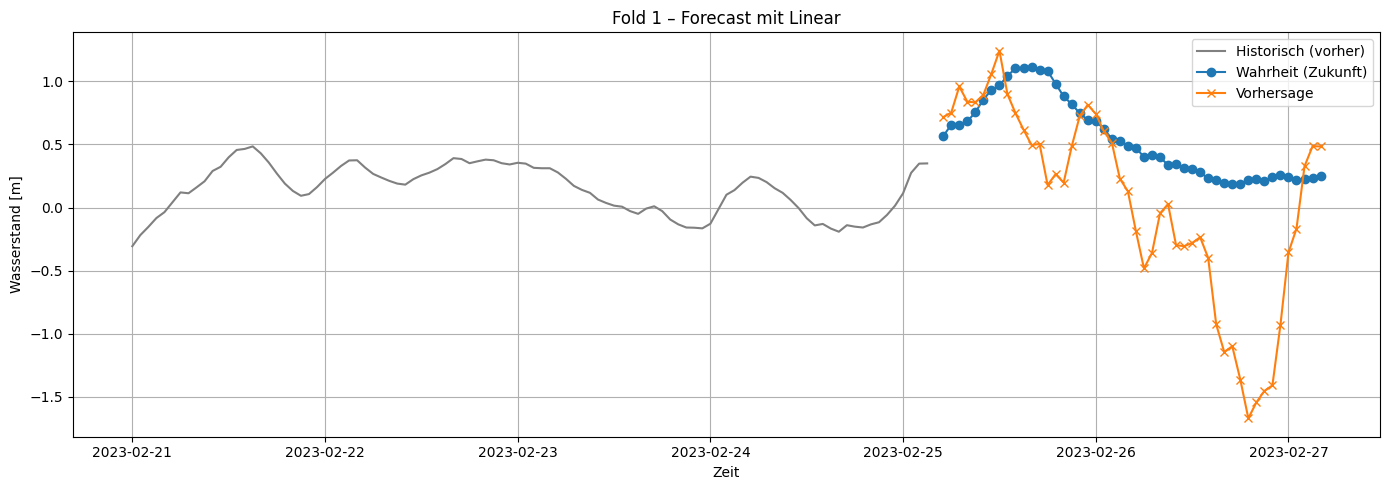


Fold 2 – Modell: Linear
X_train_scaled shape: (2639, 1356)
y_train shape: (2639, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


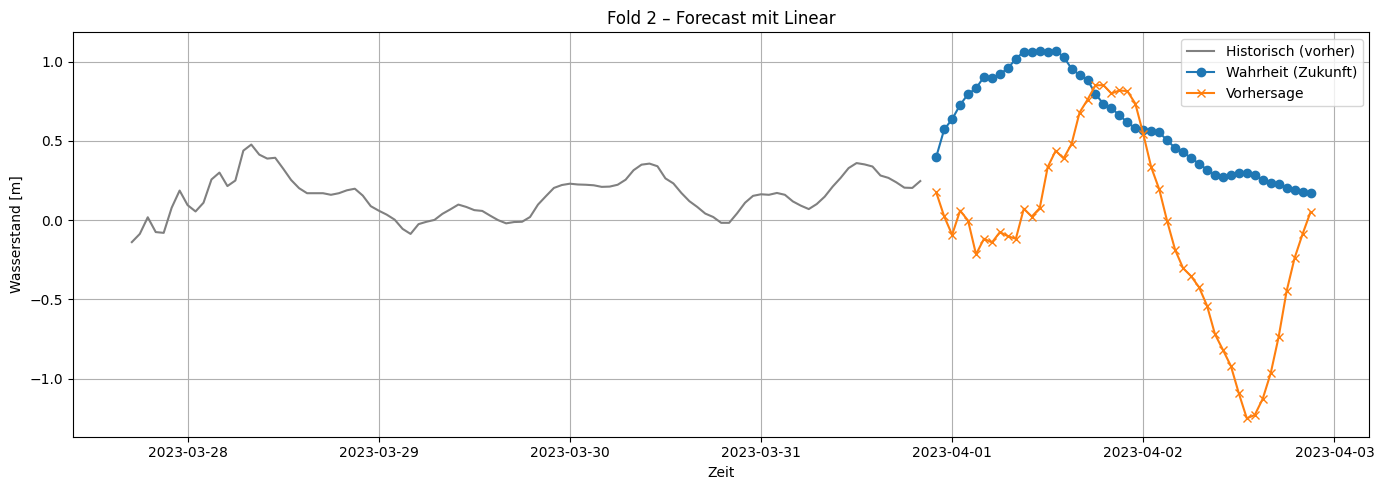


Fold 3 – Modell: Linear
X_train_scaled shape: (7499, 1356)
y_train shape: (7499, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


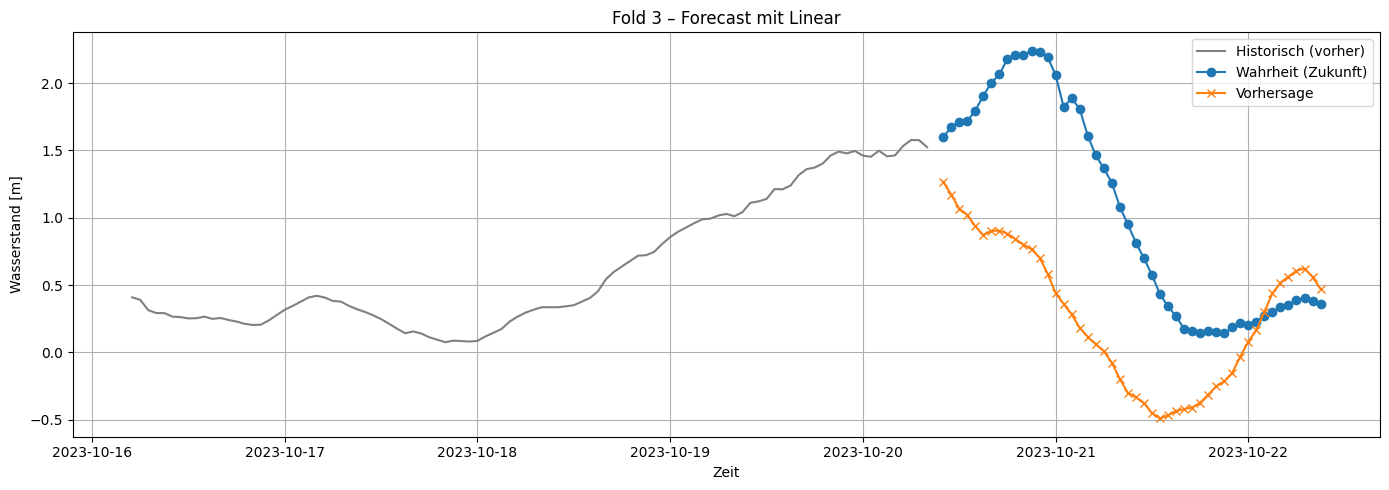


Fold 4 – Modell: Linear
X_train_scaled shape: (9279, 1356)
y_train shape: (9279, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


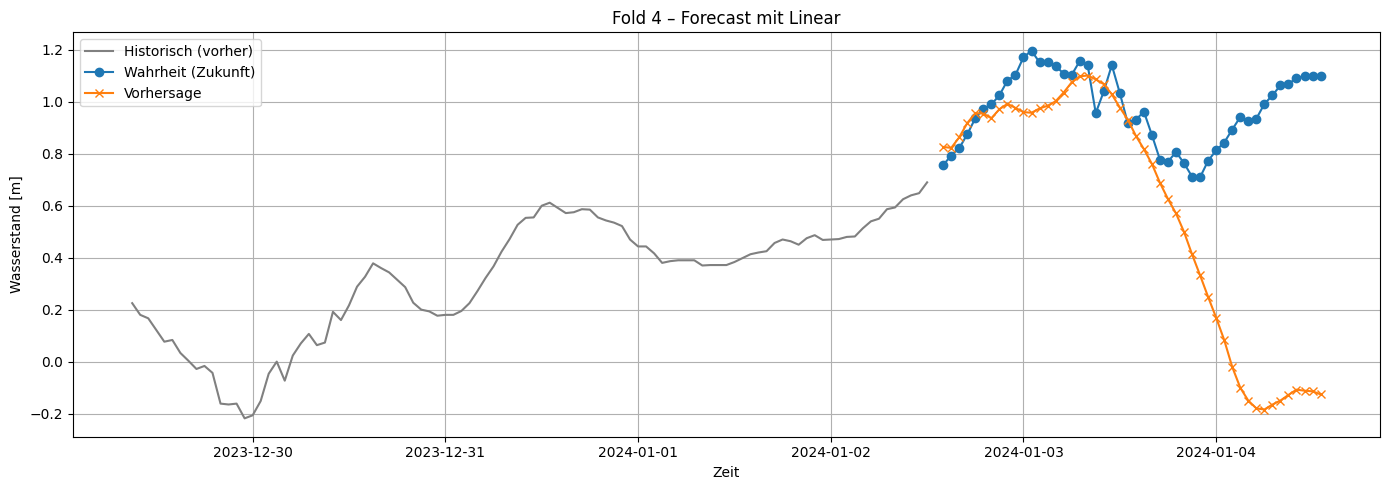


Fold 5 – Modell: Linear
X_train_scaled shape: (10181, 1356)
y_train shape: (10181, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


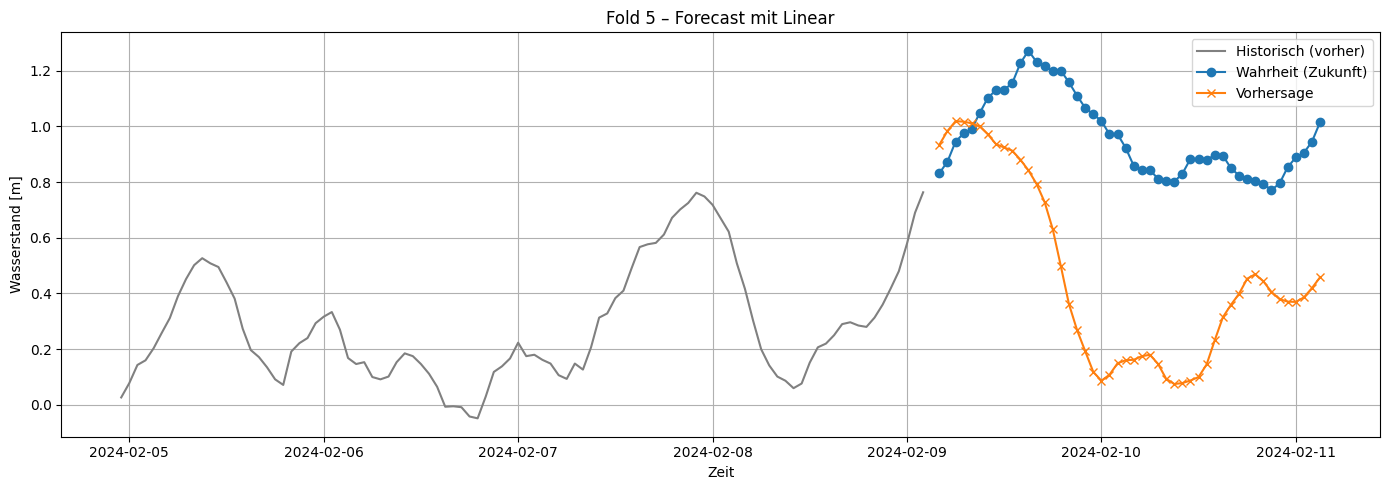


Fold 6 – Modell: Linear
X_train_scaled shape: (17472, 1356)
y_train shape: (17472, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


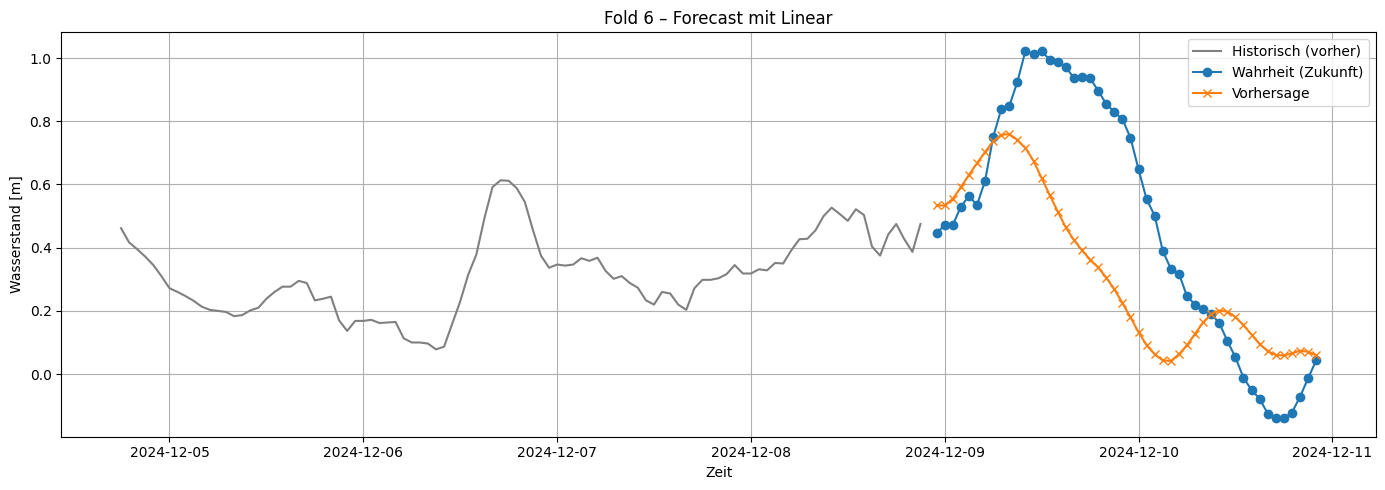


Fold 7 – Modell: Linear
X_train_scaled shape: (19540, 1356)
y_train shape: (19540, 48)
X_test_scaled shape: (1, 1356)
y_test shape: (1, 48)
y_pred shape: (1, 48)


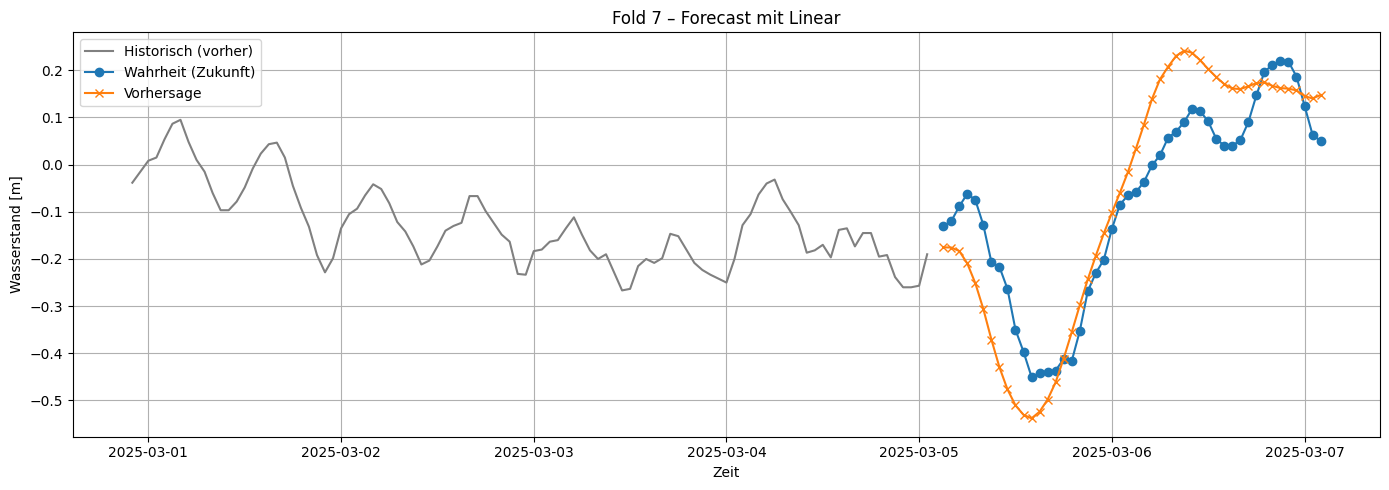

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

def create_y_target_matrix(y, horizon):
    y = np.asarray(y)
    return np.array([y[i + 1:i + 1 + horizon] for i in range(len(y) - horizon)])

# Modellwahl: eines von ['RandomForest', 'SVR', 'XGBoost', 'LGBM', 'Linear']
model_name = "Linear"

def get_model(name):
    if name == "RandomForest":
        return RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    elif name == "SVR":
        return MultiOutputRegressor(SVR(), n_jobs=-1)
    elif name == "XGBoost":
        return MultiOutputRegressor(XGBRegressor(n_estimators=500, random_state=42, n_jobs=-1), n_jobs=-1)
    elif name == "LGBM":
        return MultiOutputRegressor(LGBMRegressor(n_estimators=500, random_state=42, n_jobs=-1), n_jobs=-1)
    elif name == "Linear":
        return MultiOutputRegressor(LinearRegression(n_jobs=-1), n_jobs=-1)
    else:
        raise ValueError(f"Unbekanntes Modell: {name}")

times = [
    pd.Timestamp("2023-02-25 16:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2023-04-01 09:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2023-10-20 21:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-01-03 01:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-02-09 15:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-12-09 10:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2025-03-05 14:00:00") - pd.Timedelta(hours=12),
]

for i, time in enumerate(times):
    try:
        idx_cutoff = np.where(common_time == time)[0][0]
    except IndexError:
        print(f"Zeitpunkt {time} nicht in common_time gefunden.")
        continue

    if idx_cutoff + HORIZON > len(y):
        print(f"Nicht genug Daten nach {time} für Horizon={HORIZON}")
        continue

    train_start = 0
    train_end = idx_cutoff
    test_start = idx_cutoff
    test_end = idx_cutoff + 1

    X_train = X[train_start:train_end]
    y_lagged_train = y_lagged[train_start:train_end]
    y_target_matrix = create_y_target_matrix(y[train_start:train_end], HORIZON)

    N = min(len(X_train), len(y_lagged_train), len(y_target_matrix))
    X_train = X_train[:N]
    y_lagged_train = y_lagged_train[:N]
    y_train = y_target_matrix[:N]

    X_test = X[test_start:test_end]
    y_lagged_test = y_lagged[test_start:test_end]
    y_test = y[test_start + 1 : test_start + 1 + HORIZON].reshape(1, -1)

    X_scaler = StandardScaler()


    X_train = np.hstack([X_train.reshape(N, -1), y_lagged_train])
    X_train_scaled = X_scaler.fit_transform(X_train)
    
    X_test = np.hstack([X_test.reshape(1, -1), y_lagged_test])
    X_test_scaled = X_scaler.transform(X_test)

    # Modellwahl
    model = get_model(model_name)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"\nFold {i + 1} – Modell: {model_name}")
    print("X_train_scaled shape:", X_train_scaled.shape)
    print("y_train shape:", y_train.shape)
    print("X_test_scaled shape:", X_test_scaled.shape)
    print("y_test shape:", y_test.shape)
    print("y_pred shape:", y_pred.shape)

    # Plot
    hist_start = max(0, idx_cutoff - 100)
    historical_y = y[hist_start:idx_cutoff]
    historical_t = common_time[hist_start:idx_cutoff]
    forecast_t = common_time[idx_cutoff + 1 : idx_cutoff + 1 + HORIZON]

    plt.figure(figsize=(14, 5))
    plt.plot(historical_t, historical_y, label="Historisch (vorher)", color="gray")
    plt.plot(forecast_t, y_test.flatten(), label="Wahrheit (Zukunft)", marker="o")
    plt.plot(forecast_t, y_pred.flatten(), label="Vorhersage", marker="x")
    plt.title(f"Fold {i+1} – Forecast mit {model_name}")
    plt.xlabel("Zeit")
    plt.ylabel("Wasserstand [m]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #break  # Entfernen, um alle Folds zu durchlaufen


# DL

In [ ]:
# import all necessary libraries
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from utils.Model_ConvLSTM import CNNLSTMWaterLevelModel
from utils.config import (
    OCEAN_POINTS,
)
from utils.dl_helper_functions import (load_picture_lagged_data, 
                                       create_sequences, 
                                       create_train_val_test_split,
                                       scale_data, 
                                       convert_to_tensors)

from torch.utils.tensorboard import SummaryWriter
from utils.Model_Training import training_ConvLSTM
torch.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
pd.options.display.max_columns = None

writer = SummaryWriter()

OCEAN_POINTS = 30
GRID_SIZE = 10
HORIZON = 48

times = [
    pd.Timestamp("2023-02-25 16:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2023-04-01 09:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2023-10-20 21:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-01-03 01:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-02-09 15:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2024-12-09 10:00:00")- pd.Timedelta(hours=12),
    pd.Timestamp("2025-03-05 14:00:00") - pd.Timedelta(hours=12),
]




X, y_lagged, y, common_time = load_picture_lagged_data(return_common_time=True, verbose=False, grid_size=10)

print("Shape of X:", X.shape)
print("Shape of y_lagged:", y_lagged.shape)
print("Shape of y:", y.shape)

100%|██████████| 20161/20161 [00:02<00:00, 9710.68it/s] 


Shape of X: (19995, 13, 10, 10)
Shape of y_lagged: (19995, 56)
Shape of y: (19995,)


In [ ]:
X_seq, y_lagged_seq, y_seq = create_sequences(X, y_lagged, y, seq_len=168, horizon=HORIZON)
print("Shape of X_seq:", X_seq.shape)
print("Shape of y_lagged_seq:", y_lagged_seq.shape)
print("Shape of y_seq:", y_seq.shape)

Shape of X_seq: (19780, 168, 13, 10, 10)
Shape of y_lagged_seq: (19780, 168, 56)
Shape of y_seq: (19780, 48)


Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 16963.82it/s]



Fold 1 – Zeit: <module 'time' (built-in)>
X_train shape: (1854, 168, 13, 10, 10)
y_lagged_train shape: (1854, 168, 56)
y_train shape: (1854, 48)

Shapes of training tensors:
X_train_tensor shape: torch.Size([1854, 168, 13, 10, 10])
y_lagged_train_tensor shape: torch.Size([1854, 168, 56])
y_train_tensor shape: torch.Size([1854, 48])

Shapes of validation tensors:

Shapes of test tensors:
X_test_tensor shape: torch.Size([1, 168, 13, 10, 10])
y_lagged_test_tensor shape: torch.Size([1, 168, 56])
y_test_tensor shape: torch.Size([1, 48])

Training model with learning rate: 0.1
| Epoch 1 | Train Loss: 1.0101, Validation Loss: 0.1377 | Train MSE: 0.1151, Val MSE: 0.1377 |
| Epoch 2 | Train Loss: 0.1041, Validation Loss: 0.0983 | Train MSE: 0.0981, Val MSE: 0.0983 |
| Epoch 3 | Train Loss: 0.0970, Validation Loss: 0.0944 | Train MSE: 0.0954, Val MSE: 0.0944 |
| Epoch 4 | Train Loss: 0.0955, Validation Loss: 0.1043 | Train MSE: 0.0952, Val MSE: 0.1043 |
| Epoch 5 | Train Loss: 0.0949, Validatio

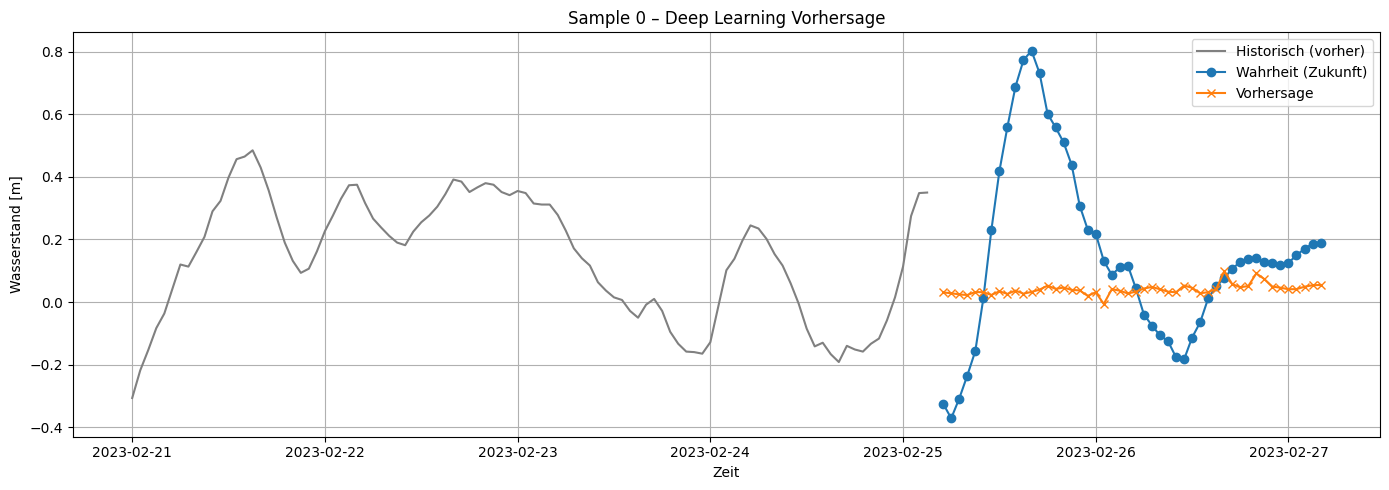

Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 16585.30it/s]



Fold 2 – Zeit: <module 'time' (built-in)>
X_train shape: (2687, 168, 13, 10, 10)
y_lagged_train shape: (2687, 168, 56)
y_train shape: (2687, 48)

Shapes of training tensors:
X_train_tensor shape: torch.Size([2687, 168, 13, 10, 10])
y_lagged_train_tensor shape: torch.Size([2687, 168, 56])
y_train_tensor shape: torch.Size([2687, 48])

Shapes of validation tensors:

Shapes of test tensors:
X_test_tensor shape: torch.Size([1, 168, 13, 10, 10])
y_lagged_test_tensor shape: torch.Size([1, 168, 56])
y_test_tensor shape: torch.Size([1, 48])

Training model with learning rate: 0.1
| Epoch 1 | Train Loss: 0.8988, Validation Loss: 0.0444 | Train MSE: 0.1134, Val MSE: 0.0444 |
| Epoch 2 | Train Loss: 0.1007, Validation Loss: 0.0219 | Train MSE: 0.0914, Val MSE: 0.0219 |
| Epoch 3 | Train Loss: 0.0898, Validation Loss: 0.0145 | Train MSE: 0.0902, Val MSE: 0.0145 |
| Epoch 4 | Train Loss: 0.0882, Validation Loss: 0.0122 | Train MSE: 0.0893, Val MSE: 0.0122 |
| Epoch 5 | Train Loss: 0.0880, Validatio

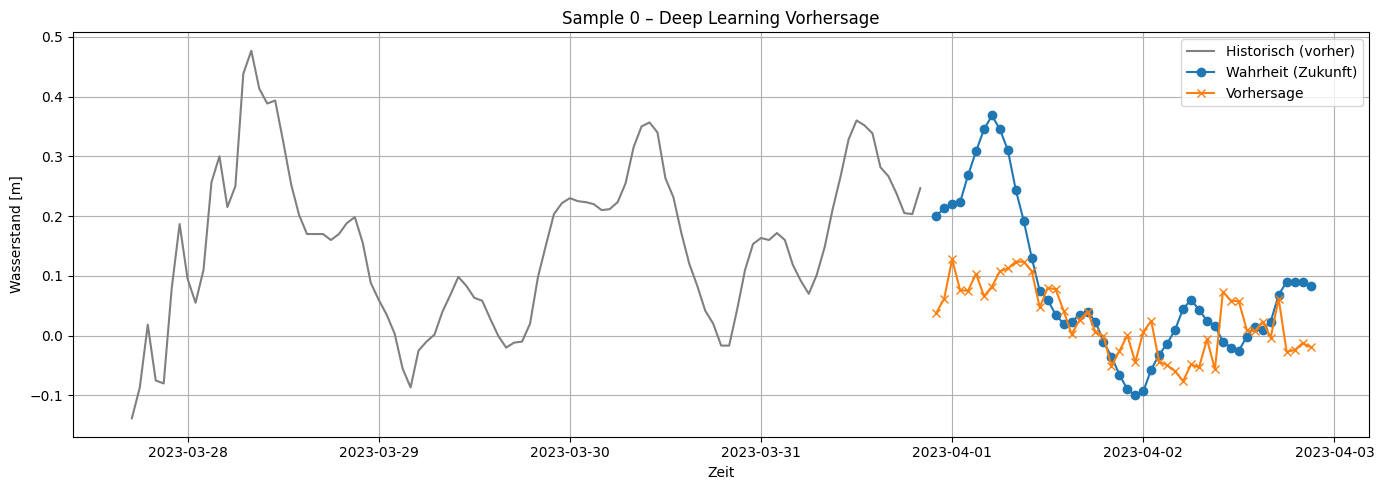

Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 16766.44it/s]



Fold 3 – Zeit: <module 'time' (built-in)>
X_train shape: (7547, 168, 13, 10, 10)
y_lagged_train shape: (7547, 168, 56)
y_train shape: (7547, 48)

Shapes of training tensors:
X_train_tensor shape: torch.Size([7547, 168, 13, 10, 10])
y_lagged_train_tensor shape: torch.Size([7547, 168, 56])
y_train_tensor shape: torch.Size([7547, 48])

Shapes of validation tensors:

Shapes of test tensors:
X_test_tensor shape: torch.Size([1, 168, 13, 10, 10])
y_lagged_test_tensor shape: torch.Size([1, 168, 56])
y_test_tensor shape: torch.Size([1, 48])

Training model with learning rate: 0.1
| Epoch 1 | Train Loss: 0.2604, Validation Loss: 0.0821 | Train MSE: 0.0793, Val MSE: 0.0821 |
| Epoch 2 | Train Loss: 0.0794, Validation Loss: 0.1040 | Train MSE: 0.0771, Val MSE: 0.1040 |
| Epoch 3 | Train Loss: 0.0786, Validation Loss: 0.0850 | Train MSE: 0.0783, Val MSE: 0.0850 |
| Epoch 4 | Train Loss: 0.0795, Validation Loss: 0.0984 | Train MSE: 0.0779, Val MSE: 0.0984 |
| Epoch 5 | Train Loss: 0.0822, Validatio

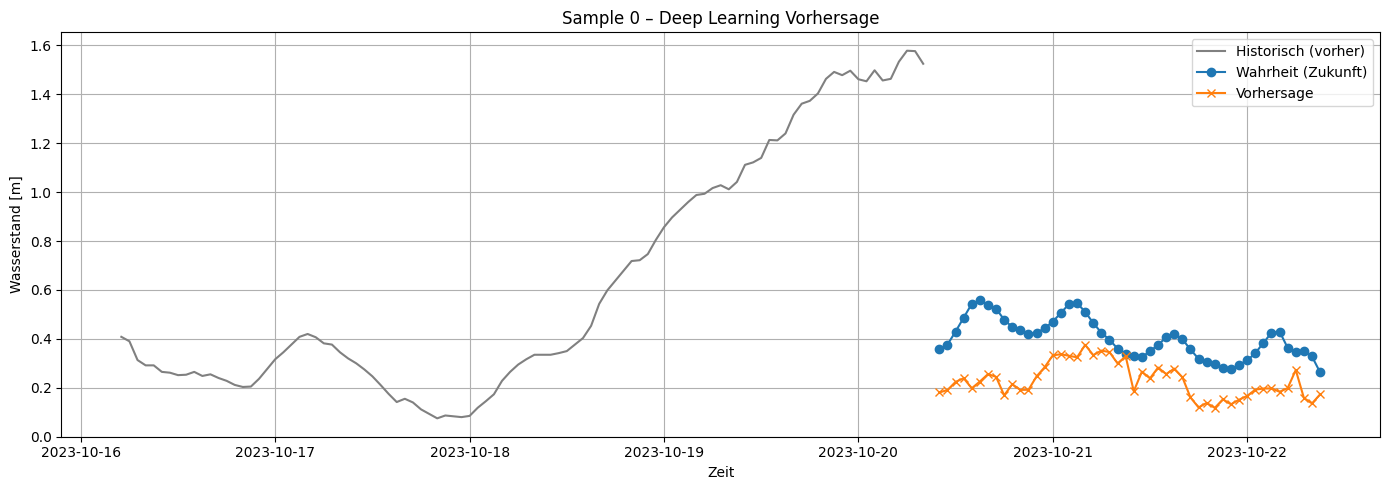

Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 16578.28it/s]



Fold 4 – Zeit: <module 'time' (built-in)>
X_train shape: (9327, 168, 13, 10, 10)
y_lagged_train shape: (9327, 168, 56)
y_train shape: (9327, 48)

Shapes of training tensors:
X_train_tensor shape: torch.Size([9327, 168, 13, 10, 10])
y_lagged_train_tensor shape: torch.Size([9327, 168, 56])
y_train_tensor shape: torch.Size([9327, 48])

Shapes of validation tensors:

Shapes of test tensors:
X_test_tensor shape: torch.Size([1, 168, 13, 10, 10])
y_lagged_test_tensor shape: torch.Size([1, 168, 56])
y_test_tensor shape: torch.Size([1, 48])

Training model with learning rate: 0.1
| Epoch 1 | Train Loss: 0.7373, Validation Loss: 0.0403 | Train MSE: 0.0900, Val MSE: 0.0403 |
| Epoch 2 | Train Loss: 0.0873, Validation Loss: 0.0434 | Train MSE: 0.0877, Val MSE: 0.0434 |
| Epoch 3 | Train Loss: 0.0899, Validation Loss: 0.0190 | Train MSE: 0.1082, Val MSE: 0.0190 |
| Epoch 4 | Train Loss: 0.0928, Validation Loss: 0.0532 | Train MSE: 0.0924, Val MSE: 0.0532 |
| Epoch 5 | Train Loss: 0.0911, Validatio

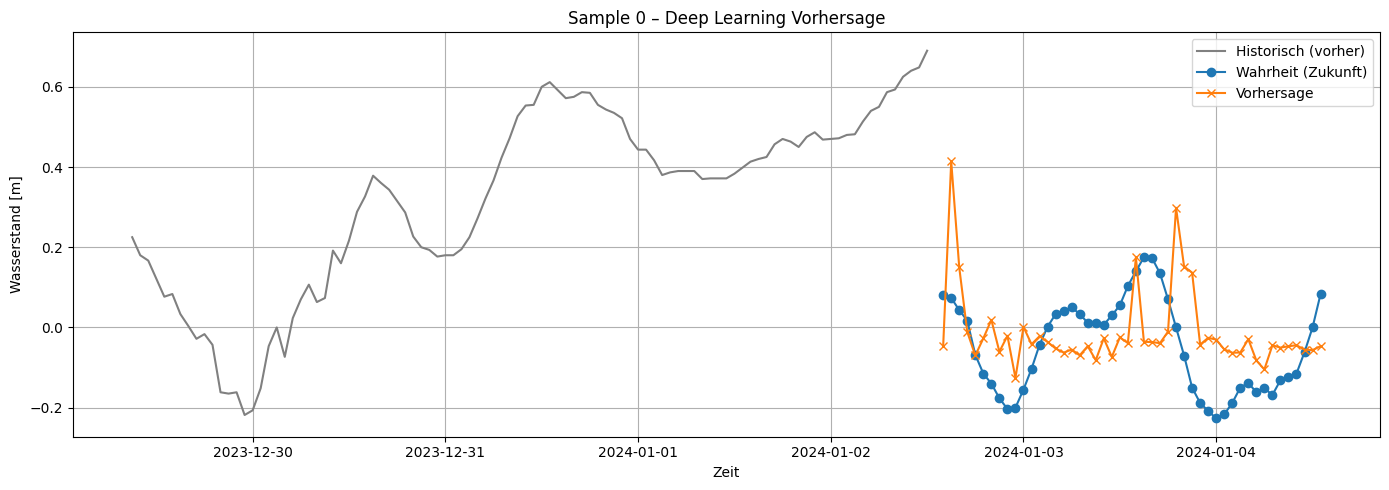

Scaling Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 17507.53it/s]



Fold 5 – Zeit: <module 'time' (built-in)>
X_train shape: (10229, 168, 13, 10, 10)
y_lagged_train shape: (10229, 168, 56)
y_train shape: (10229, 48)

Shapes of training tensors:
X_train_tensor shape: torch.Size([10229, 168, 13, 10, 10])
y_lagged_train_tensor shape: torch.Size([10229, 168, 56])
y_train_tensor shape: torch.Size([10229, 48])

Shapes of validation tensors:

Shapes of test tensors:
X_test_tensor shape: torch.Size([1, 168, 13, 10, 10])
y_lagged_test_tensor shape: torch.Size([1, 168, 56])
y_test_tensor shape: torch.Size([1, 48])

Training model with learning rate: 0.1
| Epoch 1 | Train Loss: 0.3620, Validation Loss: 0.0507 | Train MSE: 0.0915, Val MSE: 0.0507 |
| Epoch 2 | Train Loss: 0.0913, Validation Loss: 0.0484 | Train MSE: 0.0930, Val MSE: 0.0484 |
| Epoch 3 | Train Loss: 0.0916, Validation Loss: 0.0530 | Train MSE: 0.0912, Val MSE: 0.0530 |
| Epoch 4 | Train Loss: 0.0921, Validation Loss: 0.0439 | Train MSE: 0.0910, Val MSE: 0.0439 |
| Epoch 5 | Train Loss: 0.0933, Val

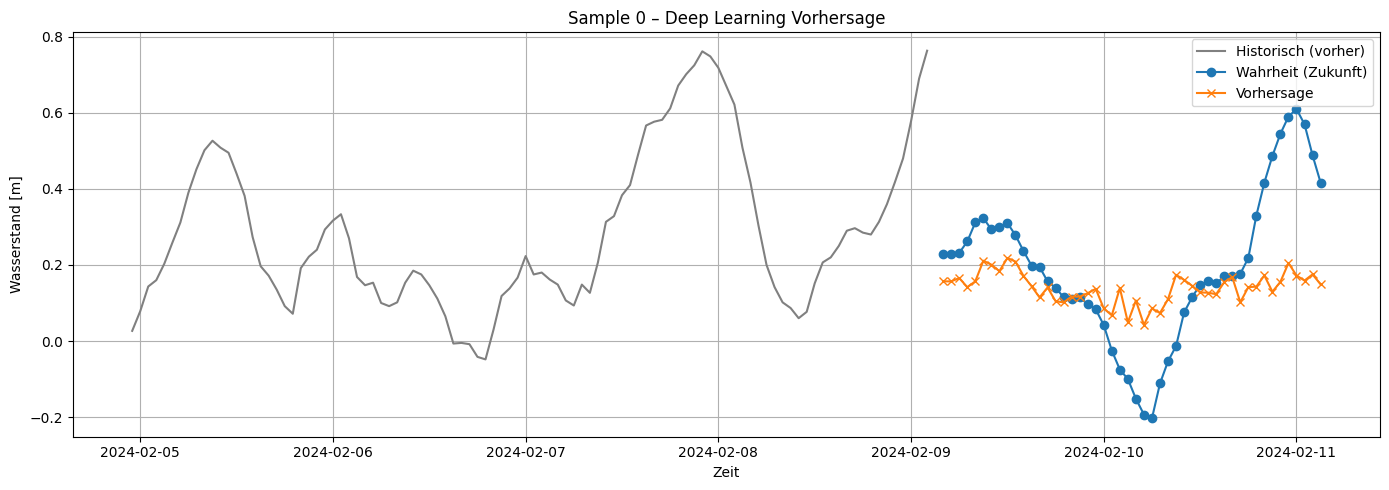

MemoryError: Unable to allocate 28.5 GiB for an array with shape (17520, 168, 13, 10, 10) and data type float64

In [ ]:



for i, time_point in enumerate(times):
    try:
        idx_cutoff = np.where(common_time == time_point)[0][0]
    except IndexError:
        print(f"Zeitpunkt {time_point} nicht in common_time gefunden.")
        continue

    if idx_cutoff + HORIZON > len(y):
        print(f"Nicht genug Daten nach {time_point} für Horizon={HORIZON}")
        continue

    train_start = 0
    train_end = idx_cutoff
    test_start = idx_cutoff
    test_end = idx_cutoff + 1

    X_train = X_seq[train_start:train_end]
    y_lagged_train = y_lagged_seq[train_start:train_end]
    y_train = y_seq[train_start:train_end]

    X_test = X_seq[test_start:test_end]
    y_lagged_test = y_lagged_seq[test_start:test_end]
    y_test = y_seq[test_start:test_end]

   
    X_scaler = StandardScaler()
    y_lagged_scaler = StandardScaler()

    data = scale_data(X_scaler=X_scaler, 
               y_lagged_scaler=y_lagged_scaler, 
               X_train=X_train, 
               y_lagged_train=y_lagged_train,
               y_train=y_train,
               X_val=None,
               y_lagged_val=None,
                y_val=None, 
               X_test=X_test, 
               y_lagged_test=y_lagged_test,
               y_test=y_test)
    
    X_train_scaled, y_lagged_train_scaled, y_train, _, _, _, X_test_scaled, y_lagged_test_scaled, y_test = data

    # X_train_scaled = X_scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    # y_lagged_train_scaled = y_lagged_scaler.fit_transform(y_lagged_train.reshape(y_lagged_train.shape[0], -1))
    # X_test_scaled = X_scaler.transform(X_test.reshape(X_test.shape[0], -1))
    # y_lagged_test_scaled = y_lagged_scaler.transform(y_lagged_test.reshape(y_lagged_test.shape[0], -1))

    print(f"\nFold {i + 1} – Zeit: {time}")
    print("X_train shape:", X_train_scaled.shape)
    print("y_lagged_train shape:", y_lagged_train_scaled.shape)
    print("y_train shape:", y_train.shape)


    # unpack the data
    data = convert_to_tensors(X_train=X_train_scaled,
                    y_lagged_train=y_lagged_train_scaled,
                    y_train=y_train,
                    X_val=None,
                    y_lagged_val=None,
                    y_val=None,
                    X_test=X_test_scaled,
                    y_lagged_test=y_lagged_test_scaled,
                    y_test=y_test,
                    dtype=torch.float32
                    )

    # unpack the data
    X_train_tensor, y_lagged_train_tensor, y_train_tensor, _, _, _, X_test_tensor, y_lagged_test_tensor, y_test_tensor = data

    print("\nShapes of training tensors:")
    print("X_train_tensor shape:", X_train_tensor.shape)
    print("y_lagged_train_tensor shape:", y_lagged_train_tensor.shape)
    print("y_train_tensor shape:", y_train_tensor.shape)
    print("\nShapes of validation tensors:")

    print("\nShapes of test tensors:")
    print("X_test_tensor shape:", X_test_tensor.shape)
    print("y_lagged_test_tensor shape:", y_lagged_test_tensor.shape)
    print("y_test_tensor shape:", y_test_tensor.shape)

    lr = 0.1
    print(f"\nTraining model with learning rate: {lr}")
    writer.add_text("hyperparameters", f"Learning Rate: {lr}")

    model = CNNLSTMWaterLevelModel(in_channels=X_train_tensor.shape[2], forecast_horizon=HORIZON, lagged_input_dim=y_lagged_train_tensor.shape[2])



    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_model = training_ConvLSTM(
        model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_val=X_test_tensor,
        y_val=y_test_tensor,
        y_lagged_train=y_lagged_train_tensor,
        y_lagged_val=y_lagged_test_tensor,
        epochs=epochs,
        batch_size=128,
        optimizer=optimizer,
        writer=writer,
        verbose=True,
        log_tensorboard=True,
    )


    # validate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model.predict(X_test_tensor, y_lagged_test_tensor)
        y_pred = y_pred.cpu().numpy()  # Konvertiere zu NumPy für weitere Verarbeitung


    y_true = y_test_tensor.cpu().numpy()  # Konvertiere zu NumPy für weitere Verarbeitung


    # get date from idx of y
    # Plotten der Vorhersagen gegen die wahren Werte
    now_ts = time.time()
    now_str = time.strftime("%Y-%m-%d_%H-%M-%S_", time.localtime(now_ts))
    print(f"Saving plots with prefix: {now_str}")

    def plot_predictions(y_true, y_pred, forecast_start_idx, common_time, HORIZON, n_samples=1):
        """
        Plottet die Vorhersagen gegen die wahren Werte mit Zeitachse und historischem Verlauf.
        forecast_start_idx: Index im Zeitverlauf, ab dem die Vorhersage beginnt.
        """
        plt.figure(figsize=(14, 5 * n_samples))

        for i in range(n_samples):
            # Zeitachsen
            hist_start = max(0, forecast_start_idx - 100)
            historical_y = y[hist_start:forecast_start_idx]
            historical_t = common_time[hist_start:forecast_start_idx]
            forecast_t = common_time[forecast_start_idx + 1 : forecast_start_idx + 1 + HORIZON]

            plt.subplot(n_samples, 1, i + 1)

            # Historie
            plt.plot(historical_t, historical_y, label="Historisch (vorher)", color="gray")

            # Ground truth
            plt.plot(forecast_t, y_true[i].flatten(), label="Wahrheit (Zukunft)", marker="o")

            # Vorhersage
            plt.plot(forecast_t, y_pred[i].flatten(), label="Vorhersage", marker="x")

            plt.title(f"Sample {i} – Deep Learning Vorhersage")
            plt.xlabel("Zeit")
            plt.ylabel("Wasserstand [m]")
            plt.legend()
            plt.grid()

        plt.tight_layout()
        # Optional speichern
        plt.savefig(f"{now_str}deep_model_forecast_plot.png", dpi=300)
        plt.show()

    plot_predictions(
        y_true=y_true,
        y_pred=y_pred,
        forecast_start_idx=idx_cutoff,
        common_time=common_time,
        HORIZON=HORIZON,
        n_samples=1
    )



    # if i == 0:
    #     break